<a href="https://colab.research.google.com/github/RochaErik/AlgorithmComparison/blob/main/AlgorithmComparison2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Balanced Datasets (Stratified)**

---

"A 10-fold cross-validation, in particular, the most commonly used error-estimation method in machine learning, can easily break down in the case of class imbalances, even if the skew is less extreme than the one previously considered."

— Page 188, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.

from: https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

---

In [80]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

# **Wine Dataset**

---

In [82]:
wine_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Wine\wine.data', header=None)

In [83]:
wine_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [84]:
wine_df.shape

(178, 14)

In [85]:
# Unbalanced dataset

wine_df[0].value_counts()

0
2    71
1    59
3    48
Name: count, dtype: int64

In [86]:
X = wine_df.iloc[:, 1:]
y = wine_df.iloc[:, 0]

In [87]:
X.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [88]:
X.shape

(178, 13)

In [89]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: 0, dtype: int64

In [90]:
y.shape

(178,)

In [91]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [92]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int64)

In [93]:
names = [
          'AdaBoost',
          'GradBoost',
          'CatBoost',
          'LightGBM',
          'XGBoost'
        ]

classifiers = [
                AdaBoostClassifier(),
                GradientBoostingClassifier(),
                CatBoostClassifier(silent=True),
                LGBMClassifier(verbosity=-1),
                XGBClassifier()
              ]

In [94]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [95]:
wine_scores = []
wine_scores_mean = []
wine_scores_std = []
model_names = []
execution_times = []

for name, clf in zip(names, classifiers):
  start_time = time.time()
  results = cross_val_score(clf, X, y, cv=rskf)
  end_time = time.time()

  wine_scores.append(results)
  wine_scores_mean.append(results.mean()*100)
  wine_scores_std.append(results.std()*100)
  model_names.append(name)
  execution_time = end_time - start_time  
  execution_times.append(execution_time)
  
  print(f'--------- {name} on Wine Dataset ---------')
  print(results)
  print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
  print(f'Execution Time: {execution_time:.2f} seconds')
  print('------------------------------')

--------- AdaBoost on Wine Dataset ---------
[1.         0.88888889 0.77777778 0.77777778 0.94444444 1.
 1.         0.77777778 0.94117647 1.         1.         0.94444444
 0.94444444 0.77777778 1.         0.94444444 1.         0.94444444
 0.82352941 1.         1.         0.83333333 0.88888889 1.
 0.94444444 0.88888889 0.77777778 1.         1.         0.82352941
 1.         1.         0.72222222 0.83333333 1.         0.83333333
 0.94444444 0.83333333 0.94117647 0.88235294 0.88888889 0.94444444
 1.         0.83333333 0.88888889 0.94444444 1.         0.94444444
 0.94117647 1.         0.94444444 0.88888889 0.83333333 0.83333333
 0.83333333 0.94444444 0.88888889 1.         1.         1.
 0.94444444 0.83333333 0.83333333 1.         0.72222222 0.94444444
 0.88888889 0.83333333 0.88235294 0.94117647 0.94444444 0.94444444
 1.         1.         1.         0.83333333 1.         0.72222222
 0.94117647 1.         1.         0.88888889 1.         0.88888889
 0.88888889 0.94444444 0.77777778 0.94444

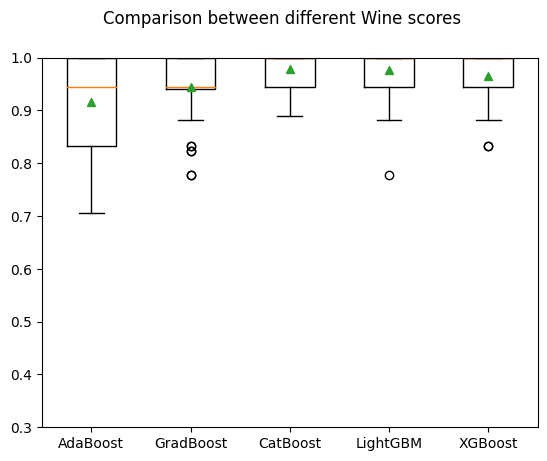

In [96]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Wine scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(wine_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [97]:
Algo_results = pd.DataFrame()
Algo_results['Names'] = names

In [98]:
Algo_results['Wine'] = wine_scores_mean

In [99]:
Algo_results

,Names,Wine
0,AdaBoost,91.696078
1,GradBoost,94.486928
2,CatBoost,97.852941
3,LightGBM,97.575163
4,XGBoost,96.614379


In [100]:
Algo_time_results = pd.DataFrame()
Algo_time_results['Names'] = names

In [101]:
Algo_time_results['Wine'] = pd.Series(execution_times)

In [102]:
Algo_time_results

,Names,Wine
0,AdaBoost,7.663740
1,GradBoost,44.714145
2,CatBoost,176.051039
3,LightGBM,4.273965
4,XGBoost,3.890878


---

# **Breast Cancer Dataset**

---

In [103]:
breast_cancer_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\BreastCancer\Breast.dat', sep=',', header=None)

In [104]:
breast_cancer_df.head()

,0,1,2,3,4,5,6,7,8,9
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [105]:
print(breast_cancer_df.shape)

(683, 10)


In [106]:
breast_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       683 non-null    int64
 1   1       683 non-null    int64
 2   2       683 non-null    int64
 3   3       683 non-null    int64
 4   4       683 non-null    int64
 5   5       683 non-null    int64
 6   6       683 non-null    int64
 7   7       683 non-null    int64
 8   8       683 non-null    int64
 9   9       683 non-null    int64
dtypes: int64(10)
memory usage: 53.5 KB


In [107]:
breast_cancer_df.nunique()

0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
8     9
9     2
dtype: int64

In [108]:
# Unbalanced dataset

breast_cancer_df[9].value_counts()

9
2    444
4    239
Name: count, dtype: int64

In [109]:
breast_cancer_df.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [110]:
X = breast_cancer_df.iloc[:, :-1]
y = breast_cancer_df.iloc[:, -1]

In [111]:
X.head()

,0,1,2,3,4,5,6,7,8
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [112]:
y.head()

0    2
1    2
2    2
3    2
4    2
Name: 9, dtype: int64

In [113]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [114]:
y

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,

In [115]:
breast_cancer_scores = []
breast_cancer_mean = []
breast_cancer_std = []
model_names = []
execution_times = []

for name, clf in zip(names, classifiers):
  start_time = time.time()
  results = cross_val_score(clf, X, y, cv=rskf)
  end_time = time.time()

  breast_cancer_scores.append(results)
  breast_cancer_mean.append(results.mean()*100)
  breast_cancer_std.append(results.std()*100)
  model_names.append(name)
  execution_time = end_time - start_time  
  execution_times.append(execution_time)

  print(f'--------- {name} on Breast Cancer Dataset ---------')
  print(results)
  print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
  print(f'Execution Time: {execution_time:.2f} seconds')
  print('------------------------------')

--------- AdaBoost on Breast Cancer Dataset ---------
[0.97101449 0.97101449 0.92753623 0.94117647 0.97058824 0.97058824
 0.94117647 0.92647059 0.95588235 0.94117647 0.95652174 0.94202899
 0.98550725 0.97058824 0.95588235 0.92647059 1.         0.89705882
 0.94117647 0.94117647 0.98550725 0.97101449 0.95652174 0.95588235
 0.94117647 0.97058824 0.95588235 0.97058824 0.92647059 0.95588235
 0.95652174 0.91304348 0.94202899 0.95588235 0.97058824 0.97058824
 0.98529412 0.94117647 0.94117647 0.97058824 0.97101449 0.95652174
 0.97101449 0.97058824 0.95588235 0.92647059 0.95588235 0.98529412
 0.94117647 0.91176471 1.         0.86956522 1.         1.
 0.92647059 0.95588235 0.95588235 0.98529412 0.92647059 0.95588235
 0.94202899 0.98550725 0.97101449 0.91176471 0.98529412 0.98529412
 0.89705882 0.97058824 0.98529412 0.97058824 0.95652174 0.97101449
 0.95652174 0.95588235 0.98529412 0.91176471 0.95588235 0.94117647
 0.95588235 0.97058824 0.97101449 0.94202899 0.94202899 0.95588235
 0.98529412 0.97

In [116]:
breast_cancer_mean

[95.62063086104006,
 96.70694799658993,
 97.173273657289,
 96.7928388746803,
 96.39855072463767]

In [117]:
breast_cancer_std

[2.4378824196461406,
 1.806078295881533,
 1.7856516046254058,
 2.099529980944241,
 2.1143142998683886]

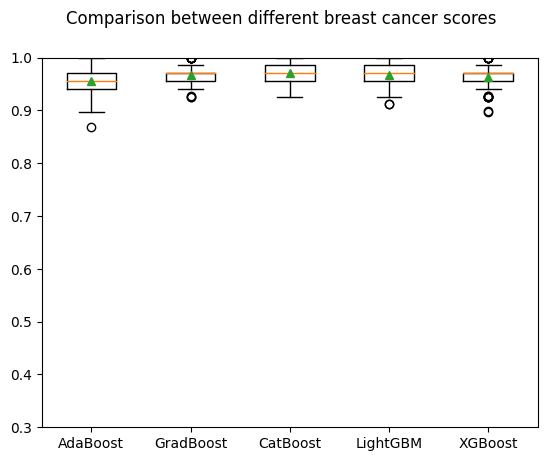

In [118]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different breast cancer scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(breast_cancer_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [119]:
Algo_results['Breast_Cancer'] = breast_cancer_mean

In [120]:
Algo_results

,Names,Wine,Breast_Cancer
0,AdaBoost,91.696078,95.620631
1,GradBoost,94.486928,96.706948
2,CatBoost,97.852941,97.173274
3,LightGBM,97.575163,96.792839
4,XGBoost,96.614379,96.398551


In [121]:
Algo_time_results['Breast_Cancer'] = pd.Series(execution_times)

---

# **Sonar Dataset** #

---

In [122]:
sonar_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Sonar\Sonar.csv', header=None)

In [123]:
sonar_df.shape

(208, 61)

In [124]:
sonar_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [125]:
sonar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

In [126]:
# A little unbalanced dataset

sonar_df[60].value_counts()

60
M    111
R     97
Name: count, dtype: int64

In [127]:
X = sonar_df.iloc[:, :-1]
y = sonar_df.iloc[:, -1]

In [128]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094


In [129]:
y.head()

0    R
1    R
2    R
3    R
4    R
Name: 60, dtype: object

In [130]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [131]:
sonar_scores = []
sonar_mean = []
sonar_std = []
model_names = []
execution_times = []


for name, clf in zip(names, classifiers):
  start_time = time.time()
  results = cross_val_score(clf, X, y, cv=rskf)
  end_time = time.time()

  sonar_scores.append(results)
  sonar_mean.append(results.mean()*100)
  sonar_std.append(results.std()*100)
  model_names.append(name)
  execution_time = end_time - start_time  
  execution_times.append(execution_time)

  print(f'--------- {name} on Sonar Dataset ---------')
  print(results)
  print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
  print(f'Execution Time: {execution_time:.2f} seconds')
  print('------------------------------')

--------- AdaBoost on Sonar Dataset ---------
[0.95238095 0.66666667 0.71428571 0.76190476 0.61904762 0.80952381
 0.71428571 0.76190476 0.8        0.9        0.76190476 0.9047619
 0.85714286 0.9047619  0.71428571 0.85714286 0.76190476 0.76190476
 0.8        0.65       0.80952381 0.80952381 0.95238095 0.9047619
 0.85714286 0.80952381 0.85714286 0.95238095 0.85       0.8
 0.95238095 0.9047619  0.85714286 0.71428571 0.80952381 0.9047619
 0.80952381 0.85714286 0.75       0.65       0.80952381 0.80952381
 0.9047619  0.57142857 0.80952381 0.85714286 0.80952381 0.66666667
 0.75       0.9        0.95238095 0.9047619  0.76190476 0.80952381
 0.76190476 0.85714286 0.85714286 0.9047619  0.9        0.8
 0.76190476 0.85714286 0.9047619  0.80952381 0.80952381 0.76190476
 0.9047619  0.9047619  0.65       1.         0.85714286 0.80952381
 0.76190476 0.9047619  0.9047619  0.80952381 0.80952381 0.85714286
 0.7        0.75       0.9047619  0.76190476 0.71428571 0.9047619
 0.80952381 0.9047619  0.85714286 

In [132]:
sonar_mean

[82.0404761904762,
 83.32619047619048,
 86.10238095238094,
 87.31428571428572,
 85.24047619047619]

In [133]:
sonar_std

[8.562446020817324,
 8.347501900680191,
 7.673662513551277,
 7.344617169093581,
 7.930715783235906]

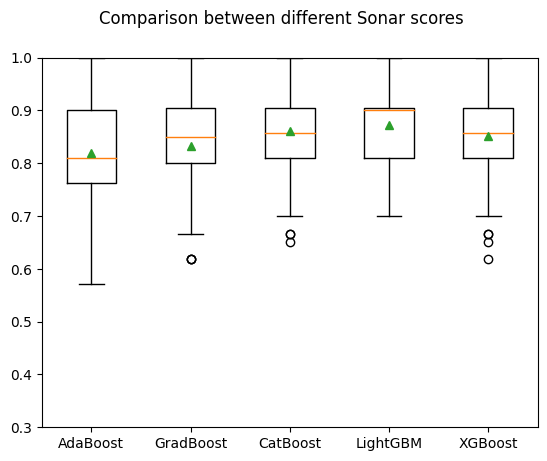

In [134]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Sonar scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(sonar_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [135]:
Algo_results['Sonar'] = sonar_mean

In [136]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar
0,AdaBoost,91.696078,95.620631,82.040476
1,GradBoost,94.486928,96.706948,83.326190
2,CatBoost,97.852941,97.173274,86.102381
3,LightGBM,97.575163,96.792839,87.314286
4,XGBoost,96.614379,96.398551,85.240476


In [137]:
Algo_time_results['Sonar'] = pd.Series(execution_times)

---

# **Ionosphere Dataset**

---

In [138]:
ionosphere_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Ionosphere\ionosphere.data', header=None)

In [139]:
ionosphere_df.shape

(351, 35)

In [140]:
ionosphere_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [141]:
ionosphere_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       351 non-null    int64  
 1   1       351 non-null    int64  
 2   2       351 non-null    float64
 3   3       351 non-null    float64
 4   4       351 non-null    float64
 5   5       351 non-null    float64
 6   6       351 non-null    float64
 7   7       351 non-null    float64
 8   8       351 non-null    float64
 9   9       351 non-null    float64
 10  10      351 non-null    float64
 11  11      351 non-null    float64
 12  12      351 non-null    float64
 13  13      351 non-null    float64
 14  14      351 non-null    float64
 15  15      351 non-null    float64
 16  16      351 non-null    float64
 17  17      351 non-null    float64
 18  18      351 non-null    float64
 19  19      351 non-null    float64
 20  20      351 non-null    float64
 21  21      351 non-null    float64
 22  22

In [142]:
ionosphere_df.nunique()

0       2
1       1
2     219
3     269
4     204
5     259
6     231
7     260
8     244
9     267
10    246
11    269
12    238
13    266
14    234
15    270
16    254
17    280
18    254
19    266
20    248
21    265
22    248
23    264
24    256
25    273
26    256
27    281
28    244
29    266
30    243
31    263
32    245
33    263
34      2
dtype: int64

In [143]:
ionosphere_df.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
dtype: int64

In [144]:
# This is a unbalanced dataset

ionosphere_df[34].value_counts()

34
g    225
b    126
Name: count, dtype: int64

In [145]:
X = ionosphere_df.iloc[:, :-1]
y = ionosphere_df.iloc[:, -1]

In [146]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697


In [147]:
y.head()

0    g
1    b
2    g
3    b
4    g
Name: 34, dtype: object

In [148]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [149]:
ionosphere_scores = []
ionosphere_mean = []
ionosphere_std = []
model_names = []
execution_times = []

for name, clf in zip(names, classifiers):
  start_time = time.time()
  results = cross_val_score(clf, X, y, cv=rskf)
  end_time = time.time()

  ionosphere_scores.append(results)
  ionosphere_mean.append(results.mean()*100)
  ionosphere_std.append(results.std()*100)
  model_names.append(name)
  execution_time = end_time - start_time  
  execution_times.append(execution_time)
  
  print(f'--------- {name} on Ionosphere Dataset ---------')
  print(results)
  print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
  print(f'Execution Time: {execution_time:.2f} seconds')
  print('------------------------------')

--------- AdaBoost on Ionosphere Dataset ---------
[1.         0.94285714 0.97142857 0.88571429 0.97142857 0.88571429
 0.91428571 1.         0.97142857 0.85714286 0.97222222 0.94285714
 0.97142857 0.97142857 0.85714286 0.91428571 0.94285714 0.91428571
 0.94285714 0.88571429 0.91666667 0.85714286 0.91428571 0.91428571
 0.94285714 0.91428571 0.91428571 0.91428571 0.97142857 0.94285714
 0.94444444 0.97142857 1.         1.         0.88571429 0.91428571
 0.8        0.94285714 0.94285714 0.88571429 0.91666667 1.
 0.97142857 0.94285714 0.94285714 0.82857143 0.94285714 0.97142857
 0.91428571 0.8        0.94444444 0.97142857 0.94285714 0.94285714
 0.94285714 0.97142857 0.97142857 0.91428571 0.94285714 0.85714286
 0.94444444 0.97142857 0.94285714 0.88571429 0.97142857 0.91428571
 0.88571429 0.94285714 0.97142857 0.97142857 0.94444444 0.91428571
 0.91428571 0.91428571 0.88571429 0.88571429 0.97142857 0.94285714
 0.94285714 0.97142857 0.86111111 0.94285714 1.         0.97142857
 0.82857143 0.97142

In [150]:
ionosphere_mean

[92.93174603174602,
 93.35952380952382,
 93.67222222222222,
 93.8452380952381,
 92.87936507936509]

In [151]:
ionosphere_std

[4.521885137893525,
 4.406042356430728,
 4.210238618114936,
 4.069136317496672,
 4.554090799304999]

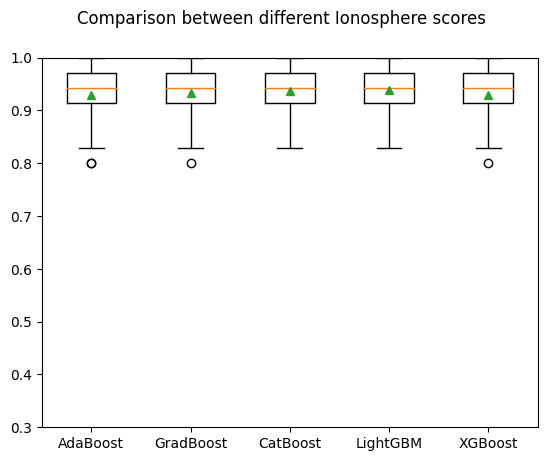

In [152]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Ionosphere scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(ionosphere_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [153]:
Algo_results['Ionosphere'] = ionosphere_mean

In [154]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere
0,AdaBoost,91.696078,95.620631,82.040476,92.931746
1,GradBoost,94.486928,96.706948,83.326190,93.359524
2,CatBoost,97.852941,97.173274,86.102381,93.672222
3,LightGBM,97.575163,96.792839,87.314286,93.845238
4,XGBoost,96.614379,96.398551,85.240476,92.879365


In [155]:
Algo_time_results['Ionosphere'] = pd.Series(execution_times)

---

# **Tic-Tac-Toe Dataset**

---

In [156]:
tictactoe_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\TicTacToe\TicTacToe.data', header=None)

In [157]:
tictactoe_df.shape

(958, 10)

In [158]:
tictactoe_df.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [159]:
tictactoe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       958 non-null    object
 1   1       958 non-null    object
 2   2       958 non-null    object
 3   3       958 non-null    object
 4   4       958 non-null    object
 5   5       958 non-null    object
 6   6       958 non-null    object
 7   7       958 non-null    object
 8   8       958 non-null    object
 9   9       958 non-null    object
dtypes: object(10)
memory usage: 75.0+ KB


In [160]:
tictactoe_df.nunique()

0    3
1    3
2    3
3    3
4    3
5    3
6    3
7    3
8    3
9    2
dtype: int64

In [161]:
# Unbalanced

tictactoe_df[9].value_counts()

9
positive    626
negative    332
Name: count, dtype: int64

In [162]:
dummies = {
            'x': 0,
            'o': 1,
            'b': 2,
          }
tictactoe_df = tictactoe_df.iloc[:, 0: 9].replace(dummies)

In [163]:
tictactoe_df.head()

,0,1,2,3,4,5,6,7,8
0,0,0,0,0,1,1,0,1,1
1,0,0,0,0,1,1,1,0,1
2,0,0,0,0,1,1,1,1,0
3,0,0,0,0,1,1,1,2,2
4,0,0,0,0,1,1,2,1,2


In [164]:
X = tictactoe_df.iloc[:, :-1]
y = tictactoe_df.iloc[:, -1]

In [165]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [166]:
tictactoe_scores = []
tictactoe_mean = []
tictactoe_std = []
model_names = []
execution_times = []

for name, clf in zip(names, classifiers):
  start_time = time.time()
  results = cross_val_score(clf, X, y, cv=rskf)
  end_time = time.time()

  tictactoe_scores.append(results)
  tictactoe_mean.append(results.mean()*100)
  tictactoe_std.append(results.std()*100)
  model_names.append(name)
  execution_time = end_time - start_time  
  execution_times.append(execution_time)

  print(f'--------- {name} on Tictactoe Dataset ---------')
  print(results)
  print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
  print(f'Execution Time: {execution_time:.2f} seconds')
  print('------------------------------')

--------- AdaBoost on Tictactoe Dataset ---------
[0.77083333 0.72916667 0.77083333 0.66666667 0.70833333 0.72916667
 0.80208333 0.69791667 0.75789474 0.74736842 0.78125    0.76041667
 0.67708333 0.66666667 0.70833333 0.73958333 0.72916667 0.83333333
 0.8        0.77894737 0.75       0.70833333 0.71875    0.76041667
 0.80208333 0.69791667 0.73958333 0.66666667 0.72631579 0.70526316
 0.79166667 0.69791667 0.75       0.72916667 0.69791667 0.75
 0.76041667 0.69791667 0.75789474 0.75789474 0.6875     0.71875
 0.77083333 0.70833333 0.71875    0.77083333 0.77083333 0.77083333
 0.75789474 0.82105263 0.77083333 0.75       0.65625    0.73958333
 0.77083333 0.6875     0.69791667 0.76041667 0.65263158 0.78947368
 0.77083333 0.71875    0.77083333 0.73958333 0.73958333 0.6875
 0.73958333 0.66666667 0.74736842 0.74736842 0.78125    0.67708333
 0.72916667 0.75       0.69791667 0.72916667 0.73958333 0.80208333
 0.74736842 0.78947368 0.72916667 0.77083333 0.75       0.77083333
 0.76041667 0.73958333 0.

In [167]:
tictactoe_mean

[73.99978070175437,
 64.27039473684209,
 51.88015350877193,
 56.33848684210526,
 45.84594298245613]

In [168]:
tictactoe_std

[3.8458296443891884,
 3.4017280692254035,
 5.007130393732132,
 4.515817954836898,
 4.745613116700222]

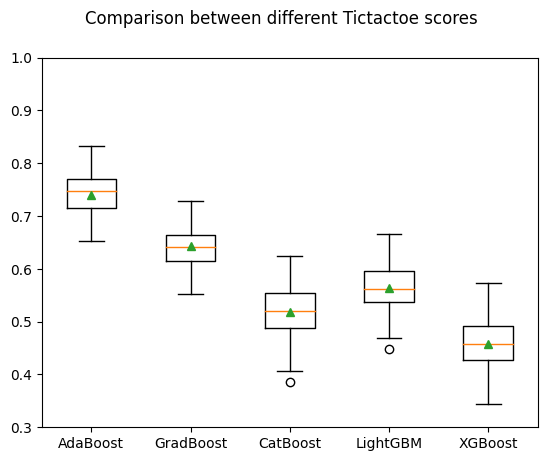

In [169]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Tictactoe scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(tictactoe_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [170]:
Algo_results['TicTacToe'] = tictactoe_mean

In [171]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe
0,AdaBoost,91.696078,95.620631,82.040476,92.931746,73.999781
1,GradBoost,94.486928,96.706948,83.326190,93.359524,64.270395
2,CatBoost,97.852941,97.173274,86.102381,93.672222,51.880154
3,LightGBM,97.575163,96.792839,87.314286,93.845238,56.338487
4,XGBoost,96.614379,96.398551,85.240476,92.879365,45.845943


In [172]:
Algo_time_results['TicTacToe'] = pd.Series(execution_times)

---

# **Bupa**

---

In [173]:
bupa_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Bupa\Bupa.data', header=None)

In [174]:
bupa_df.shape

(345, 7)

In [175]:
bupa_df.head()

,0,1,2,3,4,5,6
0,85,92,45,27,31,0.0,1
1,85,64,59,32,23,0.0,2
2,86,54,33,16,54,0.0,2
3,91,78,34,24,36,0.0,2
4,87,70,12,28,10,0.0,2


In [176]:
bupa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       345 non-null    int64  
 1   1       345 non-null    int64  
 2   2       345 non-null    int64  
 3   3       345 non-null    int64  
 4   4       345 non-null    int64  
 5   5       345 non-null    float64
 6   6       345 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 19.0 KB


In [177]:
bupa_df.nunique()

0    26
1    78
2    67
3    47
4    94
5    16
6     2
dtype: int64

In [178]:
bupa_df.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

In [179]:
# Unbalanced dataset

bupa_df[6].value_counts()

6
2    200
1    145
Name: count, dtype: int64

In [180]:
X = bupa_df.iloc[:, :-1]
y = bupa_df.iloc[:, -1]

In [181]:
X.head()

,0,1,2,3,4,5
0,85,92,45,27,31,0.0
1,85,64,59,32,23,0.0
2,86,54,33,16,54,0.0
3,91,78,34,24,36,0.0
4,87,70,12,28,10,0.0


In [182]:
y.head()

0    1
1    2
2    2
3    2
4    2
Name: 6, dtype: int64

In [183]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [184]:
bupa_scores = []
bupa_mean = []
bupa_std = []
model_names = []
execution_times = []

for name, clf in zip(names, classifiers):
  start_time = time.time()
  results = cross_val_score(clf, X, y, cv=rskf)
  end_time = time.time()

  bupa_scores.append(results)
  bupa_mean.append(results.mean()*100)
  bupa_std.append(results.std()*100)
  model_names.append(name)
  execution_time = end_time - start_time  
  execution_times.append(execution_time)

  print(f'--------- {name} on Bupa Dataset ---------')
  print(results)
  print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
  print(f'Execution Time: {execution_time:.2f} seconds')
  print('------------------------------')

--------- AdaBoost on Bupa Dataset ---------
[0.8        0.74285714 0.6        0.8        0.68571429 0.82352941
 0.76470588 0.64705882 0.70588235 0.76470588 0.77142857 0.54285714
 0.48571429 0.8        0.65714286 0.73529412 0.88235294 0.64705882
 0.73529412 0.79411765 0.77142857 0.6        0.68571429 0.82857143
 0.74285714 0.73529412 0.79411765 0.58823529 0.64705882 0.76470588
 0.77142857 0.8        0.65714286 0.77142857 0.74285714 0.79411765
 0.55882353 0.76470588 0.82352941 0.67647059 0.77142857 0.77142857
 0.74285714 0.62857143 0.8        0.76470588 0.67647059 0.64705882
 0.73529412 0.73529412 0.71428571 0.77142857 0.74285714 0.68571429
 0.71428571 0.73529412 0.73529412 0.76470588 0.61764706 0.64705882
 0.77142857 0.91428571 0.65714286 0.65714286 0.68571429 0.76470588
 0.70588235 0.79411765 0.79411765 0.67647059 0.77142857 0.62857143
 0.82857143 0.82857143 0.68571429 0.79411765 0.79411765 0.64705882
 0.67647059 0.70588235 0.77142857 0.77142857 0.77142857 0.8
 0.68571429 0.61764706 0

In [185]:
bupa_mean

[72.86974789915966,
 72.96554621848739,
 74.59579831932773,
 72.14621848739496,
 71.1453781512605]

In [186]:
bupa_std

[7.414006930412971,
 7.330576263235048,
 6.89718592223879,
 7.651263226871813,
 6.813355571039844]

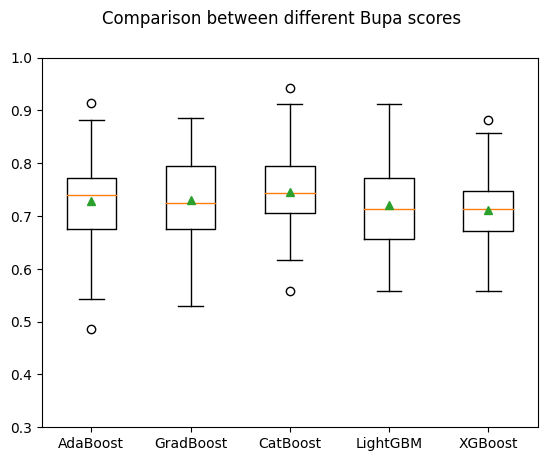

In [187]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Bupa scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(bupa_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [188]:
Algo_results['Bupa'] = bupa_mean

In [189]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa
0,AdaBoost,91.696078,95.620631,82.040476,92.931746,73.999781,72.869748
1,GradBoost,94.486928,96.706948,83.326190,93.359524,64.270395,72.965546
2,CatBoost,97.852941,97.173274,86.102381,93.672222,51.880154,74.595798
3,LightGBM,97.575163,96.792839,87.314286,93.845238,56.338487,72.146218
4,XGBoost,96.614379,96.398551,85.240476,92.879365,45.845943,71.145378


In [190]:
Algo_time_results['Bupa'] = pd.Series(execution_times)

---

# **Pima**

---

In [191]:
pima_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Pima\Diabetes.csv')

In [192]:
pima_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [193]:
pima_df.shape

(768, 9)

In [194]:
pima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [195]:
pima_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [196]:
pima_df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [197]:
# It is a unbalanced dataset

pima_df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [198]:
X = pima_df.iloc[:, :-1]
y = pima_df.iloc[:, -1]

In [199]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [200]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [201]:
pima_scores = []
pima_mean = []
pima_std = []
model_names = []
execution_times = []

for name, clf in zip(names, classifiers):
  start_time = time.time()
  results = cross_val_score(clf, X, y, cv=rskf)
  end_time = time.time()

  pima_scores.append(results)
  pima_mean.append(results.mean()*100)
  pima_std.append(results.std()*100)
  model_names.append(name)
  execution_time = end_time - start_time  
  execution_times.append(execution_time)

  print(f'--------- {name} on Pima Dataset ---------')
  print(results)
  print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
  print(f'Execution Time: {execution_time:.2f} seconds')
  print('------------------------------')

--------- AdaBoost on Pima Dataset ---------
[0.74025974 0.77922078 0.7012987  0.84415584 0.81818182 0.7012987
 0.74025974 0.75324675 0.71052632 0.72368421 0.71428571 0.68831169
 0.72727273 0.75324675 0.76623377 0.83116883 0.80519481 0.7012987
 0.65789474 0.80263158 0.76623377 0.74025974 0.83116883 0.71428571
 0.75324675 0.76623377 0.72727273 0.74025974 0.73684211 0.67105263
 0.79220779 0.72727273 0.68831169 0.74025974 0.83116883 0.7012987
 0.75324675 0.81818182 0.76315789 0.63157895 0.74025974 0.75324675
 0.83116883 0.75324675 0.79220779 0.79220779 0.68831169 0.79220779
 0.71052632 0.71052632 0.79220779 0.74025974 0.75324675 0.7012987
 0.77922078 0.79220779 0.63636364 0.74025974 0.72368421 0.73684211
 0.77922078 0.75324675 0.75324675 0.76623377 0.76623377 0.77922078
 0.72727273 0.72727273 0.72368421 0.77631579 0.77922078 0.72727273
 0.74025974 0.81818182 0.71428571 0.74025974 0.75324675 0.75324675
 0.71052632 0.73684211 0.75324675 0.72727273 0.81818182 0.79220779
 0.80519481 0.8051948

In [202]:
pima_mean

[75.09962406015038,
 76.20625427204376,
 76.3086124401914,
 74.55297334244703,
 73.91626794258374]

In [203]:
pima_std

[4.355035334186671,
 4.099370974123496,
 4.221326546518267,
 4.249331092789857,
 3.9269103357209207]

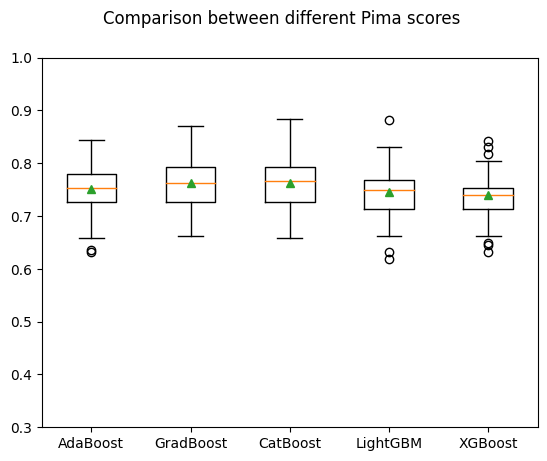

In [204]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Pima scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(pima_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [205]:
Algo_results['Pima'] = pima_mean

In [206]:
Algo_time_results['Pima'] = pd.Series(execution_times)

---

# **Heart**

---

In [247]:
heart_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Heart\Heart.csv')

In [248]:
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,presence
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [249]:
heart_df.shape

(270, 14)

In [250]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       270 non-null    float64
 1   sex       270 non-null    float64
 2   cp        270 non-null    float64
 3   trestbps  270 non-null    float64
 4   chol      270 non-null    float64
 5   fbs       270 non-null    float64
 6   restecg   270 non-null    float64
 7   thalach   270 non-null    float64
 8   exang     270 non-null    float64
 9   oldpeak   270 non-null    float64
 10  slope     270 non-null    float64
 11  ca        270 non-null    float64
 12  thal      270 non-null    float64
 13  presence  270 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 29.7 KB


In [251]:
heart_df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
presence    0
dtype: int64

In [252]:
# Almost balanced dataset

heart_df['presence'].value_counts()

presence
1    150
2    120
Name: count, dtype: int64

In [253]:
X = heart_df.iloc[:, :-1]
y = heart_df.iloc[:, -1]

In [254]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0


In [255]:
y.head()

0    2
1    1
2    2
3    1
4    1
Name: presence, dtype: int64

In [256]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [257]:
y

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1], dtype=int64)

In [258]:
heart_scores = []
heart_mean = []
heart_std = []
model_names = []
execution_times = []

for name, clf in zip(names, classifiers):
  start_time = time.time()
  results = cross_val_score(clf, X, y, cv=rskf)
  end_time = time.time()

  heart_scores.append(results)
  heart_mean.append(results.mean()*100)
  heart_std.append(results.std()*100)
  model_names.append(name)
  execution_time = end_time - start_time  
  execution_times.append(execution_time)
  
  print(f'--------- {name} on Heart Dataset ---------')
  print(results)
  print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
  print(f'Execution Time: {execution_time:.2f} seconds')
  print('------------------------------')

--------- AdaBoost on Heart Dataset ---------
[0.81481481 0.81481481 0.81481481 0.92592593 0.7037037  0.74074074
 0.81481481 0.62962963 0.81481481 0.85185185 0.7037037  0.81481481
 0.88888889 0.77777778 0.85185185 0.77777778 0.92592593 0.55555556
 0.77777778 0.81481481 0.77777778 0.88888889 0.77777778 0.74074074
 0.77777778 0.85185185 0.85185185 0.7037037  0.81481481 0.81481481
 0.81481481 0.81481481 0.7037037  0.77777778 0.74074074 0.96296296
 0.77777778 0.77777778 0.77777778 0.77777778 0.85185185 0.85185185
 0.81481481 0.74074074 0.7037037  0.85185185 0.81481481 0.77777778
 0.81481481 0.81481481 0.62962963 0.77777778 0.77777778 0.88888889
 0.77777778 0.85185185 0.77777778 0.81481481 0.81481481 0.85185185
 0.85185185 0.81481481 0.81481481 0.85185185 0.81481481 0.7037037
 0.7037037  0.74074074 0.74074074 0.92592593 0.92592593 0.85185185
 0.74074074 0.88888889 0.85185185 0.77777778 0.74074074 0.92592593
 0.77777778 0.85185185 0.85185185 0.88888889 0.77777778 0.77777778
 0.7037037  0.851

In [259]:
heart_mean

[79.99999999999999,
 79.99999999999999,
 82.33333333333331,
 81.22222222222223,
 80.5925925925926]

In [260]:
heart_std

[6.909169668954678,
 6.542045086168775,
 6.454547210937164,
 6.671911517112698,
 6.331492043365363]

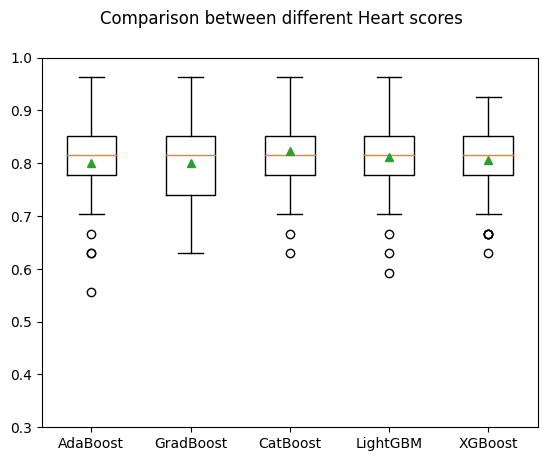

In [261]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Heart scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(heart_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [262]:
Algo_results['Heart'] = heart_mean

In [263]:
Algo_time_results['Heart'] = pd.Series(execution_times)

---

# **Liver**

---

In [264]:
liver_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Liver\Bupa.data', header=None)

In [265]:
liver_df.shape

(345, 7)

In [266]:
liver_df.head()

,0,1,2,3,4,5,6
0,85,92,45,27,31,0.0,1
1,85,64,59,32,23,0.0,2
2,86,54,33,16,54,0.0,2
3,91,78,34,24,36,0.0,2
4,87,70,12,28,10,0.0,2


In [267]:
liver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       345 non-null    int64  
 1   1       345 non-null    int64  
 2   2       345 non-null    int64  
 3   3       345 non-null    int64  
 4   4       345 non-null    int64  
 5   5       345 non-null    float64
 6   6       345 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 19.0 KB


In [268]:
liver_df.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

In [269]:
# Unbalanced dataset

liver_df[6].value_counts()

6
2    200
1    145
Name: count, dtype: int64

In [270]:
X = liver_df.iloc[:, :-1]
y = liver_df.iloc[:, -1]

In [271]:
X.head()

,0,1,2,3,4,5
0,85,92,45,27,31,0.0
1,85,64,59,32,23,0.0
2,86,54,33,16,54,0.0
3,91,78,34,24,36,0.0
4,87,70,12,28,10,0.0


In [272]:
y.head()

0    1
1    2
2    2
3    2
4    2
Name: 6, dtype: int64

In [273]:
# Since version 1.3.2 XGBoost needs target columns to start with 0 value

le = LabelEncoder()
y = le.fit_transform(y)

In [274]:
y

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [275]:
liver_scores = []
liver_mean = []
liver_std = []
model_names = []
execution_times = []

for name, clf in zip(names, classifiers):
  start_time = time.time()
  results = cross_val_score(clf, X, y, cv=rskf)
  end_time = time.time()

  liver_scores.append(results)
  liver_mean.append(results.mean()*100)
  liver_std.append(results.std()*100)
  model_names.append(name)
  execution_time = end_time - start_time  
  execution_times.append(execution_time)

  print(f'--------- {name} on Liver Dataset ---------')
  print(results)
  print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))
  print(f'Execution Time: {execution_time:.2f} seconds')
  print('------------------------------')

--------- AdaBoost on Liver Dataset ---------
[0.8        0.74285714 0.6        0.8        0.68571429 0.82352941
 0.76470588 0.64705882 0.70588235 0.76470588 0.77142857 0.54285714
 0.48571429 0.8        0.65714286 0.73529412 0.88235294 0.64705882
 0.73529412 0.79411765 0.77142857 0.6        0.68571429 0.82857143
 0.74285714 0.73529412 0.79411765 0.58823529 0.64705882 0.76470588
 0.77142857 0.8        0.65714286 0.77142857 0.74285714 0.79411765
 0.55882353 0.76470588 0.82352941 0.67647059 0.77142857 0.77142857
 0.74285714 0.62857143 0.8        0.76470588 0.67647059 0.64705882
 0.73529412 0.73529412 0.71428571 0.77142857 0.74285714 0.68571429
 0.71428571 0.73529412 0.73529412 0.76470588 0.61764706 0.64705882
 0.77142857 0.91428571 0.65714286 0.65714286 0.68571429 0.76470588
 0.70588235 0.79411765 0.79411765 0.67647059 0.77142857 0.62857143
 0.82857143 0.82857143 0.68571429 0.79411765 0.79411765 0.64705882
 0.67647059 0.70588235 0.77142857 0.77142857 0.77142857 0.8
 0.68571429 0.61764706 

In [276]:
liver_mean

[72.86974789915966,
 72.87899159663866,
 74.59579831932773,
 72.14621848739496,
 71.1453781512605]

In [277]:
liver_std

[7.414006930412971,
 7.33321839875865,
 6.89718592223879,
 7.651263226871813,
 6.813355571039844]

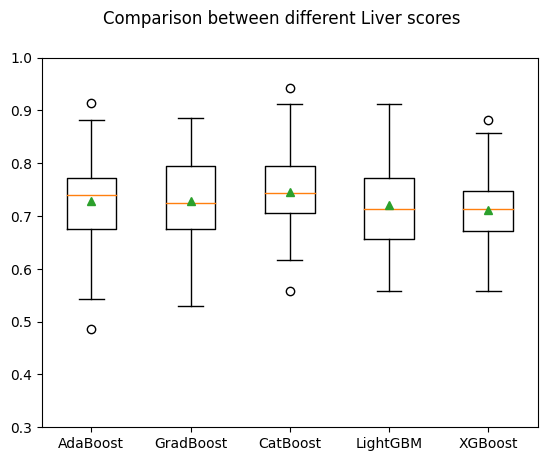

In [278]:
# algorithm comparison

fig = plt.figure()
fig.suptitle('Comparison between different Liver scores')
ax = fig.add_subplot(111)
plt.ylim(0.3, 1)
plt.boxplot(liver_scores, showmeans=True)
ax.set_xticklabels(model_names)
plt.show()

In [279]:
Algo_results['Liver'] = liver_mean

In [280]:
Algo_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa,Pima,Heart,Liver
0,AdaBoost,91.696078,95.620631,82.040476,92.931746,73.999781,72.869748,75.099624,80.000000,72.869748
1,GradBoost,94.486928,96.706948,83.326190,93.359524,64.270395,72.965546,76.206254,80.000000,72.878992
2,CatBoost,97.852941,97.173274,86.102381,93.672222,51.880154,74.595798,76.308612,82.333333,74.595798
3,LightGBM,97.575163,96.792839,87.314286,93.845238,56.338487,72.146218,74.552973,81.222222,72.146218
4,XGBoost,96.614379,96.398551,85.240476,92.879365,45.845943,71.145378,73.916268,80.592593,71.145378


In [281]:
Strat_Algo_results_tr = Algo_results.set_index('Names').T

In [290]:
Strat_Algo_results_tr.to_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\StratAlgoResults.csv', index=False)

In [283]:
Strat_Algo_results_tr

Names,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
Wine,91.696078,94.486928,97.852941,97.575163,96.614379
Breast_Cancer,95.620631,96.706948,97.173274,96.792839,96.398551
Sonar,82.040476,83.326190,86.102381,87.314286,85.240476
Ionosphere,92.931746,93.359524,93.672222,93.845238,92.879365
TicTacToe,73.999781,64.270395,51.880154,56.338487,45.845943
Bupa,72.869748,72.965546,74.595798,72.146218,71.145378
Pima,75.099624,76.206254,76.308612,74.552973,73.916268
Heart,80.000000,80.000000,82.333333,81.222222,80.592593
Liver,72.869748,72.878992,74.595798,72.146218,71.145378


In [284]:
Algo_time_results['Liver'] = pd.Series(execution_times)

In [285]:
Algo_time_results

,Names,Wine,Breast_Cancer,Sonar,Ionosphere,TicTacToe,Bupa,Pima,Heart,Liver
0,AdaBoost,7.663740,6.763525,17.336914,14.721323,7.132614,6.436452,8.410844,6.165462,6.754525
1,GradBoost,44.714145,8.422902,72.544376,55.386888,27.543217,8.885006,18.438176,9.242087,9.025037
2,CatBoost,176.051039,131.680051,378.379707,315.377411,105.860007,136.621315,173.964505,147.828947,139.536585
3,LightGBM,4.273965,4.468008,2.350529,4.179942,12.158745,2.173491,4.773077,2.377537,2.410544
4,XGBoost,3.890878,3.221727,5.584261,4.841093,12.432807,3.263736,5.413222,3.655824,3.530435


In [311]:
Strat_Algo_time_results_tr = Algo_time_results.set_index('Names').T

In [312]:
Strat_Algo_time_results_tr.to_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\StratAlgoTimeResults.csv', index=False)

---

# **Friedman's Test**

---

In [ ]:
!pip install scikit-posthocs

In [294]:
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare

In [291]:
Strat_Algo_results_tr = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\StratAlgoResults.csv')

In [292]:
Strat_Algo_results_tr

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
0,91.696078,94.486928,97.852941,97.575163,96.614379
1,95.620631,96.706948,97.173274,96.792839,96.398551
2,82.040476,83.326190,86.102381,87.314286,85.240476
3,92.931746,93.359524,93.672222,93.845238,92.879365
4,73.999781,64.270395,51.880154,56.338487,45.845943
5,72.869748,72.965546,74.595798,72.146218,71.145378
6,75.099624,76.206254,76.308612,74.552973,73.916268
7,80.000000,80.000000,82.333333,81.222222,80.592593
8,72.869748,72.878992,74.595798,72.146218,71.145378


In [295]:
stat, p_value = friedmanchisquare(Strat_Algo_results_tr['AdaBoost'], Strat_Algo_results_tr['GradBoost'], Strat_Algo_results_tr['CatBoost'], Strat_Algo_results_tr['LightGBM'], Strat_Algo_results_tr['XGBoost'])

In [296]:
p_value

0.0036451586102761494

In [297]:
alpha = 0.05
if p_value < alpha:
    print('There are significant differences among the models.')
else:
    print('There are no significant differences among the models.')

There are significant differences among the models.


---

# **Nemenyi test**

---

In [298]:
nemenyi_results = sp.posthoc_nemenyi_friedman(a=Strat_Algo_results_tr)

In [299]:
nemenyi_results

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
AdaBoost,1.000000,0.813139,0.030006,0.517029,0.900000
GradBoost,0.813139,1.000000,0.337399,0.900000,0.426737
CatBoost,0.030006,0.337399,1.000000,0.643932,0.003195
LightGBM,0.517029,0.900000,0.643932,1.000000,0.166548
XGBoost,0.900000,0.426737,0.003195,0.166548,1.000000


In [300]:
alpha = 0.05

# Print p-values for all pairs of models
for i in range(nemenyi_results.shape[0]):
    for j in range(i + 1, nemenyi_results.shape[1]):
        model1 = i + 1
        model2 = j + 1
        p_value = nemenyi_results.iloc[i, j]

        if p_value < alpha:
            print(f"Models {model1} and {model2} are significantly different (p-value = {p_value:.4f}).")
        else:
            print(f"Models {model1} and {model2} are not significantly different (p-value = {p_value:.4f}).")

Models 1 and 2 are not significantly different (p-value = 0.8131).
Models 1 and 3 are significantly different (p-value = 0.0300).
Models 1 and 4 are not significantly different (p-value = 0.5170).
Models 1 and 5 are not significantly different (p-value = 0.9000).
Models 2 and 3 are not significantly different (p-value = 0.3374).
Models 2 and 4 are not significantly different (p-value = 0.9000).
Models 2 and 5 are not significantly different (p-value = 0.4267).
Models 3 and 4 are not significantly different (p-value = 0.6439).
Models 3 and 5 are significantly different (p-value = 0.0032).
Models 4 and 5 are not significantly different (p-value = 0.1665).


---

# **Algorithms running time Friedman's Test**

---

In [313]:
Strat_Algo_time_results_tr = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\StratAlgoTimeResults.csv')

In [314]:
Strat_Algo_time_results_tr

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
0,7.663740,44.714145,176.051039,4.273965,3.890878
1,6.763525,8.422902,131.680051,4.468008,3.221727
2,17.336914,72.544376,378.379707,2.350529,5.584261
3,14.721323,55.386888,315.377411,4.179942,4.841093
4,7.132614,27.543217,105.860007,12.158745,12.432807
5,6.436452,8.885006,136.621315,2.173491,3.263736
6,8.410844,18.438176,173.964505,4.773077,5.413222
7,6.165462,9.242087,147.828947,2.377537,3.655824
8,6.754525,9.025037,139.536585,2.410544,3.530435


In [315]:
stat, p_value = friedmanchisquare(Strat_Algo_time_results_tr['AdaBoost'], Strat_Algo_time_results_tr['GradBoost'], Strat_Algo_time_results_tr['CatBoost'], Strat_Algo_time_results_tr['LightGBM'], Strat_Algo_time_results_tr['XGBoost'])

In [316]:
p_value

1.427247840702767e-06

In [317]:
alpha = 0.05
if p_value < alpha:
    print('There are significant differences among the models.')
else:
    print('There are no significant differences among the models.')

There are significant differences among the models.


---

# **Algorithms running time Nemenyi test**

---

In [323]:
nemenyi_results = sp.posthoc_nemenyi_friedman(a=Strat_Algo_time_results_tr)

In [324]:
nemenyi_results

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
AdaBoost,1.000000,0.472825,0.023982,0.297254,0.728536
GradBoost,0.472825,1.000000,0.643932,0.003195,0.037299
CatBoost,0.023982,0.643932,1.000000,0.001000,0.001000
LightGBM,0.297254,0.003195,0.001000,1.000000,0.900000
XGBoost,0.728536,0.037299,0.001000,0.900000,1.000000


In [325]:
alpha = 0.05

# Print p-values for all pairs of models
for i in range(nemenyi_results.shape[0]):
    for j in range(i + 1, nemenyi_results.shape[1]):
        model1 = i + 1
        model2 = j + 1
        p_value = nemenyi_results.iloc[i, j]

        if p_value < alpha:
            print(f"Models {model1} and {model2} are significantly different (p-value = {p_value:.4f}).")
        else:
            print(f"Models {model1} and {model2} are not significantly different (p-value = {p_value:.4f}).")

Models 1 and 2 are not significantly different (p-value = 0.4728).
Models 1 and 3 are significantly different (p-value = 0.0240).
Models 1 and 4 are not significantly different (p-value = 0.2973).
Models 1 and 5 are not significantly different (p-value = 0.7285).
Models 2 and 3 are not significantly different (p-value = 0.6439).
Models 2 and 4 are significantly different (p-value = 0.0032).
Models 2 and 5 are significantly different (p-value = 0.0373).
Models 3 and 4 are significantly different (p-value = 0.0010).
Models 3 and 5 are significantly different (p-value = 0.0010).
Models 4 and 5 are not significantly different (p-value = 0.9000).


---

# **Comparison between the balanced and unbalanced dataset algorithm performance**

---

In [1]:
import scipy.stats as stats

In [3]:
unbalanced_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\AlgoResults.csv')
balanced_df = pd.read_csv('E:\Cursos\MestradoCienciaComputação\Seminario\Datasets\Algo_Results\StratAlgoResults.csv')

In [4]:
print(unbalanced_df.shape)
print(balanced_df.shape)

(9, 5)
(9, 5)


In [5]:
unbalanced_df

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
0,89.830065,95.016340,97.977124,97.421569,96.676471
1,95.800512,96.574169,97.087170,96.632992,96.429028
2,83.188095,84.276190,87.152381,88.123810,85.007143
3,93.027778,92.943651,93.453175,93.706349,92.430159
4,73.707456,64.354715,51.491228,55.961513,45.988816
5,72.254622,72.440336,74.403361,71.801681,70.579832
6,75.118592,76.235988,76.249316,73.985133,73.842447
7,79.814815,80.074074,81.888889,80.888889,80.370370
8,72.254622,72.292437,74.403361,71.801681,70.579832


In [6]:
balanced_df

,AdaBoost,GradBoost,CatBoost,LightGBM,XGBoost
0,91.696078,94.486928,97.852941,97.575163,96.614379
1,95.620631,96.706948,97.173274,96.792839,96.398551
2,82.040476,83.326190,86.102381,87.314286,85.240476
3,92.931746,93.359524,93.672222,93.845238,92.879365
4,73.999781,64.270395,51.880154,56.338487,45.845943
5,72.869748,72.965546,74.595798,72.146218,71.145378
6,75.099624,76.206254,76.308612,74.552973,73.916268
7,80.000000,80.000000,82.333333,81.222222,80.592593
8,72.869748,72.878992,74.595798,72.146218,71.145378


In [ ]:
datasets = ['Wine', 'Breast Cancer', 'Sonar', 'Ionosphere', 'TicTacToe', 'Bupa', 'Pima', 'Heart', 'Liver']

In [ ]:
for i, name in enumerate(datasets):
  # Creating two lists of paired data
  before = unbalanced_df.iloc[i, :]
  after = balanced_df.iloc[i, :]

  # Performing the Wilcoxon signed-rank test
  statistic, p_value = stats.wilcoxon(before, after)

  print (f'Comparison between {name} models results')

  # Printing the test statistic and p-value
  print(f"Test Statistic: {statistic}")
  print(f"P-value: {p_value}")

  # Interpreting the results
  alpha = 0.05
  if p_value < alpha:
      print(f'Reject the null hypothesis: There is a significant difference between {name} models.')
  else:
      print(f'Fail to reject the null hypothesis: There is no significant difference between {name} models.')
  print ('- - - - - - - - - - - - - - - - - - - - -')

Comparison between Wine models results
Test Statistic: 7.0
P-value: 1.0
Fail to reject the null hypothesis: There is no significant difference between Wine models.
- - - - - - - - - - - - - - - - - - - - -
Comparison between Breast Cancer models results
Test Statistic: 6.0
P-value: 0.8125
Fail to reject the null hypothesis: There is no significant difference between Breast Cancer models.
- - - - - - - - - - - - - - - - - - - - -
Comparison between Sonar models results
Test Statistic: 1.0
P-value: 0.125
Fail to reject the null hypothesis: There is no significant difference between Sonar models.
- - - - - - - - - - - - - - - - - - - - -
Comparison between Ionosphere models results
Test Statistic: 1.0
P-value: 0.125
Fail to reject the null hypothesis: There is no significant difference between Ionosphere models.
- - - - - - - - - - - - - - - - - - - - -
Comparison between TicTacToe models results
Test Statistic: 3.0
P-value: 0.3125
Fail to reject the null hypothesis: There is no significa